In [1]:
#!/usr/bin/python
# vim:ts=4:sts=4:sw=4:et:wrap:ai:fileencoding=utf-8:
import json
import math
import numpy as np
import pandas as pd
from random import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from scipy.optimize import curve_fit
from scipy.misc import factorial
from IPython.display import Image
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Preparing data
##### assistances without shots (shot region=0) means assistances where the striker couldn't get the ball

In [2]:
df = pd.read_csv("data/shots_2016.csv", sep=";")

In [3]:
columns = df.columns.tolist()
columns[:21]
cols_to_use = columns[:21] # drop unused columns
cols_to_use
shots_df = pd.read_csv("data/shots_2016.csv", sep=";", usecols=cols_to_use)
shots_df.head()

,index,week,goal,minute,shot_player,assistance_player,team,opponent,region_assistance,region_shot,...,at_home,type_of_play,type_of_shot,dribble_before_shot,deep_pass,cross,counter_attack,good_chance,defense_mistake,dangerous_shot
0,1,1,1,NaN,everton,Willian Arao,Flamengo,Sport,5,3,...,1,collective,foot,0,0,1,0,1,1,1
1,2,1,0,NaN,Diego Souza,-,Sport,Flamengo,0,26,...,0,direct_fk,foot,0,0,0,0,0,0,0
2,3,1,0,NaN,everton,Mancuello,Flamengo,Sport,28,5,...,1,collective,foot,0,1,0,0,1,0,0
3,4,1,0,NaN,Guerrero,Everton,Flamengo,Sport,18,18,...,1,collective,foot,0,0,0,0,0,0,0
4,5,1,0,NaN,Rodinei,-,Flamengo,Sport,0,15,...,1,individual,foot,1,0,0,0,0,0,0


In [4]:
match_df = pd.read_csv("data/match_data_2016.csv", sep=";")
match_df.head()

,week,home_team,away_team,home_goals,away_goals,week_day,time,home_passes,home_wrong_passes,away_passes,...,home_shots_on_target,home_shots_off_target,away_shots_on_target,away_shots_off_target,home_fouls,away_fouls,home_tackles,home_wrong_tackles,away_tackles,away_wrong_tackles
0,1,Flamengo,Sport,1,0,SAT,16,471,41,322,...,5,6,1,0,18,15,24,1,19,3
1,1,Atletico MG,Santos,1,0,SAT,18,249,37,444,...,6,15,4,8,17,11,26,6,9,2
2,1,Coritiba,Cruzeiro,1,0,SAT,21,304,41,349,...,6,8,1,3,20,22,17,3,19,2
3,1,Corinthians,Gremio,0,0,SUN,16,470,44,283,...,1,15,2,4,12,19,24,1,22,3
4,1,Botafogo,Sao Paulo,0,1,SUN,11,434,32,189,...,6,5,1,3,8,10,9,1,17,4


In [5]:
shots_df["team"] = shots_df["team"].str.strip()     # some strings have unecessary whitespace at the end
shots_df["opponent"] = shots_df["opponent"].str.strip()
shots_df["shot_player"] = shots_df["shot_player"].str.strip()
shots_df["assistance_player"] = shots_df["assistance_player"].str.strip()

match_df["home_team"] = match_df["home_team"].str.strip()
match_df["away_team"] = match_df["away_team"].str.strip()
set(shots_df["team"])

{'America',
 'Atletico MG',
 'Atletico PR',
 'Botafogo',
 'Chapecoense',
 'Corinthians',
 'Coritiba',
 'Cruzeiro',
 'Figueirense',
 'Flamengo',
 'Fluminense',
 'Gremio',
 'Internacional',
 'Palmeiras',
 'Ponte Preta',
 'Santa Cruz',
 'Santos',
 'Sao Paulo',
 'Sport',
 'Vitoria'}

In [6]:
shots_df.dtypes

index                    int64
week                     int64
goal                     int64
minute                 float64
shot_player             object
assistance_player       object
team                    object
opponent                object
region_assistance        int64
region_shot              int64
goal_difference          int64
at_home                  int64
type_of_play            object
type_of_shot            object
dribble_before_shot      int64
deep_pass                int64
cross                    int64
counter_attack           int64
good_chance              int64
defense_mistake          int64
dangerous_shot           int64
dtype: object

In [7]:
# the values for the regions of the shots and assistances aren't numerical, but categorical
shots_df["region_shot"] = shots_df["region_shot"].astype('category')
shots_df["region_assistance"] = shots_df["region_assistance"].astype('category')

# the values of binary variables aren't numerical - we must convert to boolean
bool_map = {1: True, 0: False}

# shots_df["goal"] = shots_df["goal"].map(bool_map)
# shots_df["at_home"] = shots_df["at_home"].map(bool_map)
# shots_df["dribble_before_shot"] = shots_df["dribble_before_shot"].map(bool_map)
# shots_df["deep_pass"] = shots_df["deep_pass"].map(bool_map)
# shots_df["cross"] = shots_df["cross"].map(bool_map)
# shots_df["counter_attack"] = shots_df["counter_attack"].map(bool_map)
# shots_df["good_chance"] = shots_df["good_chance"].map(bool_map)
# shots_df["defense_mistake"] = shots_df["defense_mistake"].map(bool_map)
# shots_df["dangerous_shot"] = shots_df["dangerous_shot"].map(bool_map)

shots_df.head()

,index,week,goal,minute,shot_player,assistance_player,team,opponent,region_assistance,region_shot,...,at_home,type_of_play,type_of_shot,dribble_before_shot,deep_pass,cross,counter_attack,good_chance,defense_mistake,dangerous_shot
0,1,1,1,NaN,everton,Willian Arao,Flamengo,Sport,5,3,...,1,collective,foot,0,0,1,0,1,1,1
1,2,1,0,NaN,Diego Souza,-,Sport,Flamengo,0,26,...,0,direct_fk,foot,0,0,0,0,0,0,0
2,3,1,0,NaN,everton,Mancuello,Flamengo,Sport,28,5,...,1,collective,foot,0,1,0,0,1,0,0
3,4,1,0,NaN,Guerrero,Everton,Flamengo,Sport,18,18,...,1,collective,foot,0,0,0,0,0,0,0
4,5,1,0,NaN,Rodinei,-,Flamengo,Sport,0,15,...,1,individual,foot,1,0,0,0,0,0,0


# Analyzing variables

In [8]:
shots_df["goal"].value_counts()

0    3905
1     866
dtype: int64

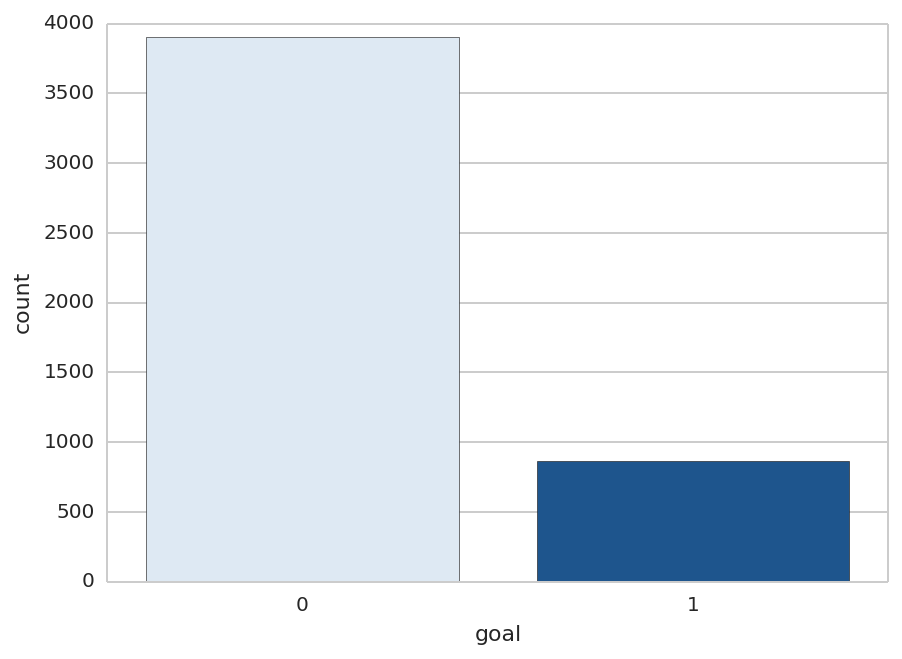

In [9]:
mpl.rcParams['figure.figsize'] = (7,5)
# palette = sns.diverging_palette(220, 10, sep=80, n=2)
palette = [sns.color_palette("Blues")[0], sns.color_palette("Blues")[-1]]
sns.countplot(x="goal", data=shots_df, palette=palette)
plt.show()

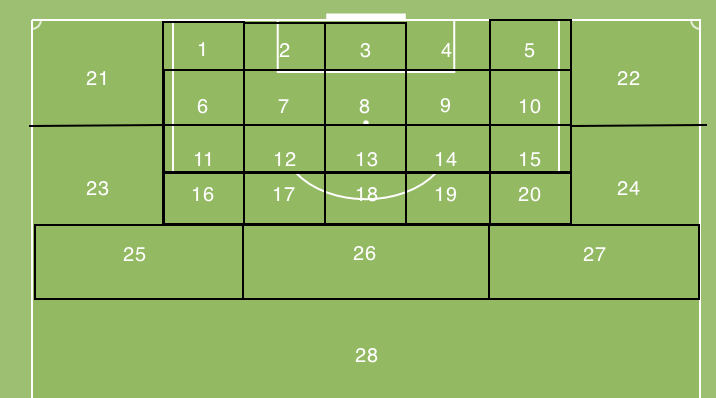

In [10]:
Image(filename = "map.png", width=500, height=500)
# region assistance = 0 means no assistance

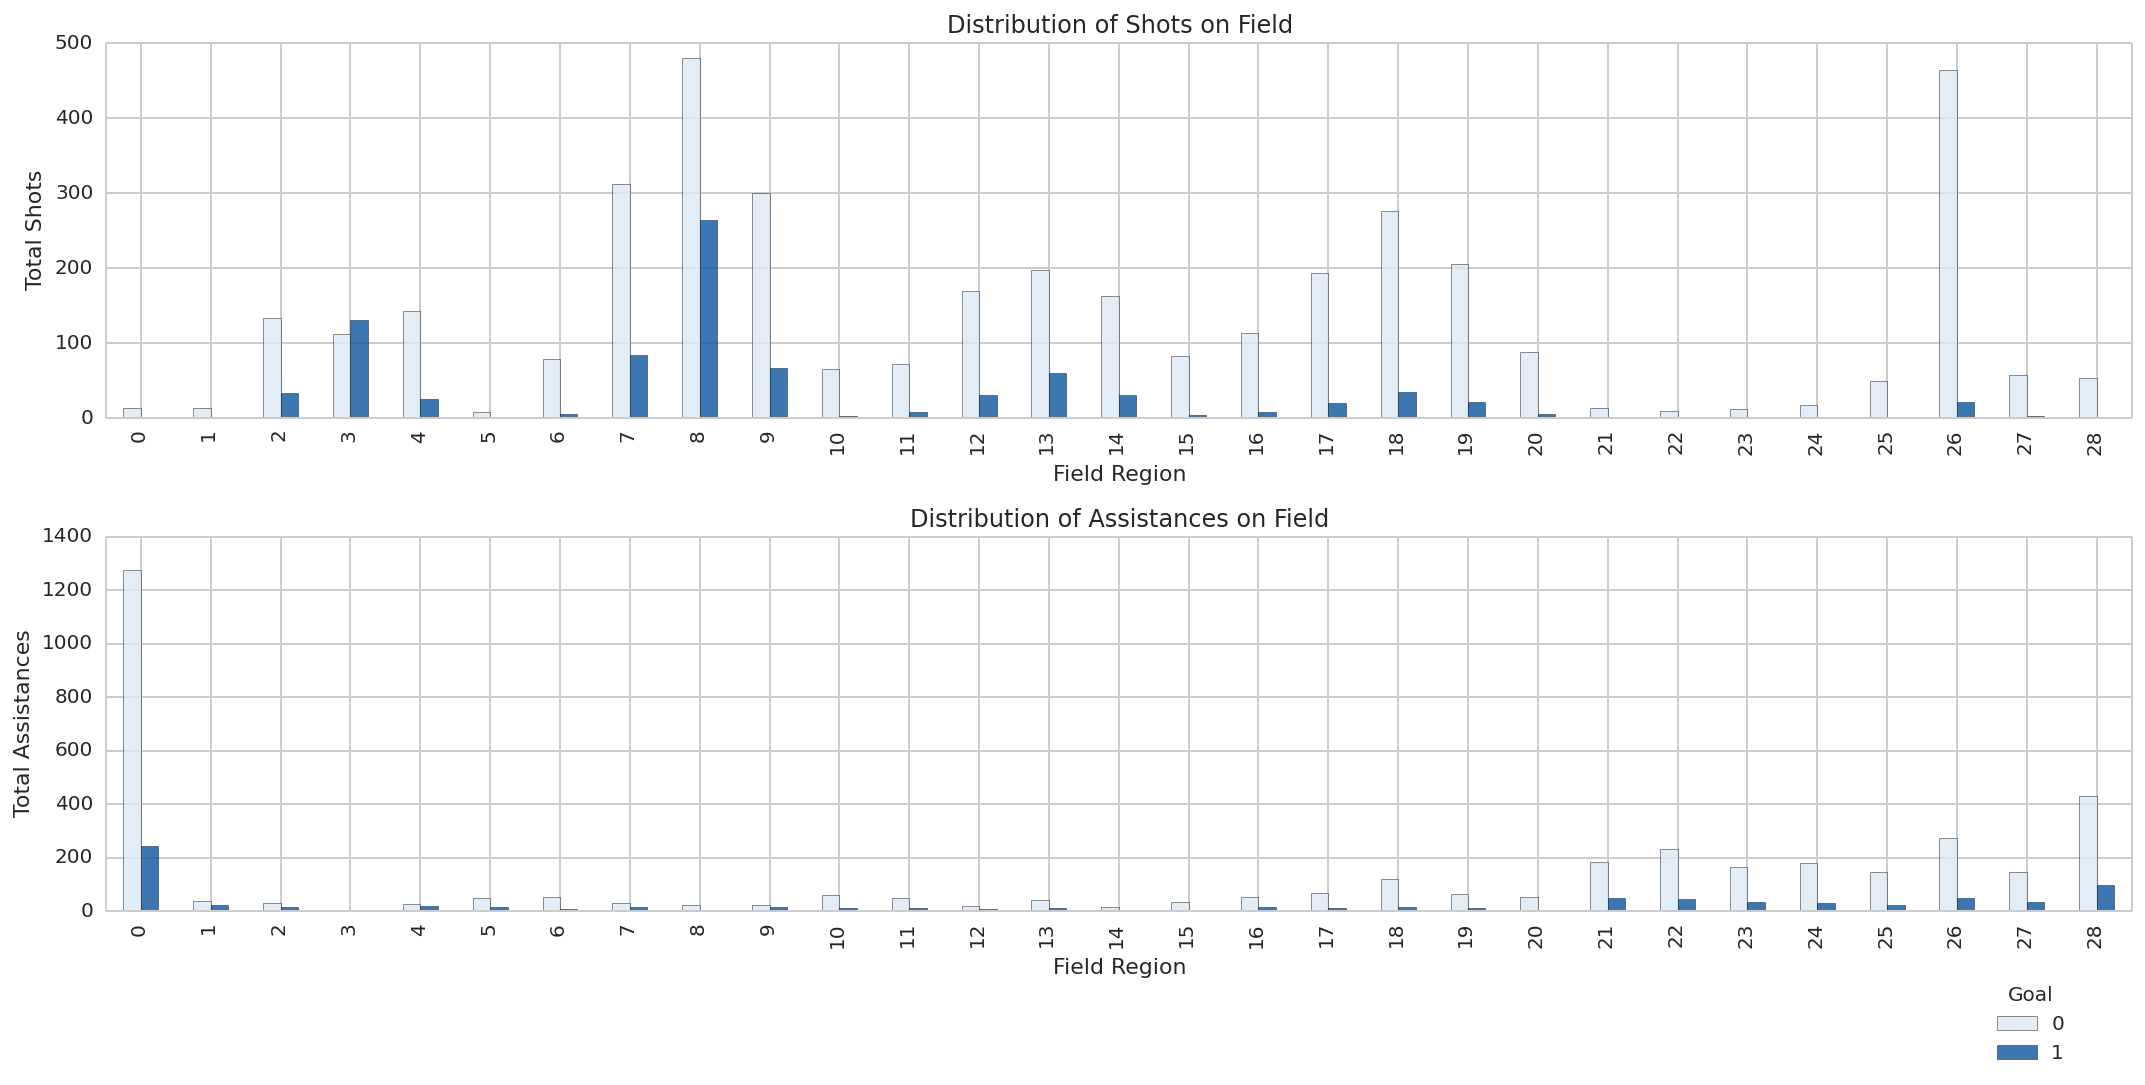

In [11]:
mpl.rcParams['figure.figsize'] = (15,7)
fig,(ax1,ax2) = plt.subplots(2)

pd.crosstab(shots_df.region_shot,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Distribution of Shots on Field')
ax1.set_xlabel('Field Region')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

pd.crosstab(shots_df.region_assistance,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Distribution of Assistances on Field')
ax2.set_xlabel('Field Region')
ax2.set_ylabel('Total Assistances')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.15), title="Goal")
fig.tight_layout()


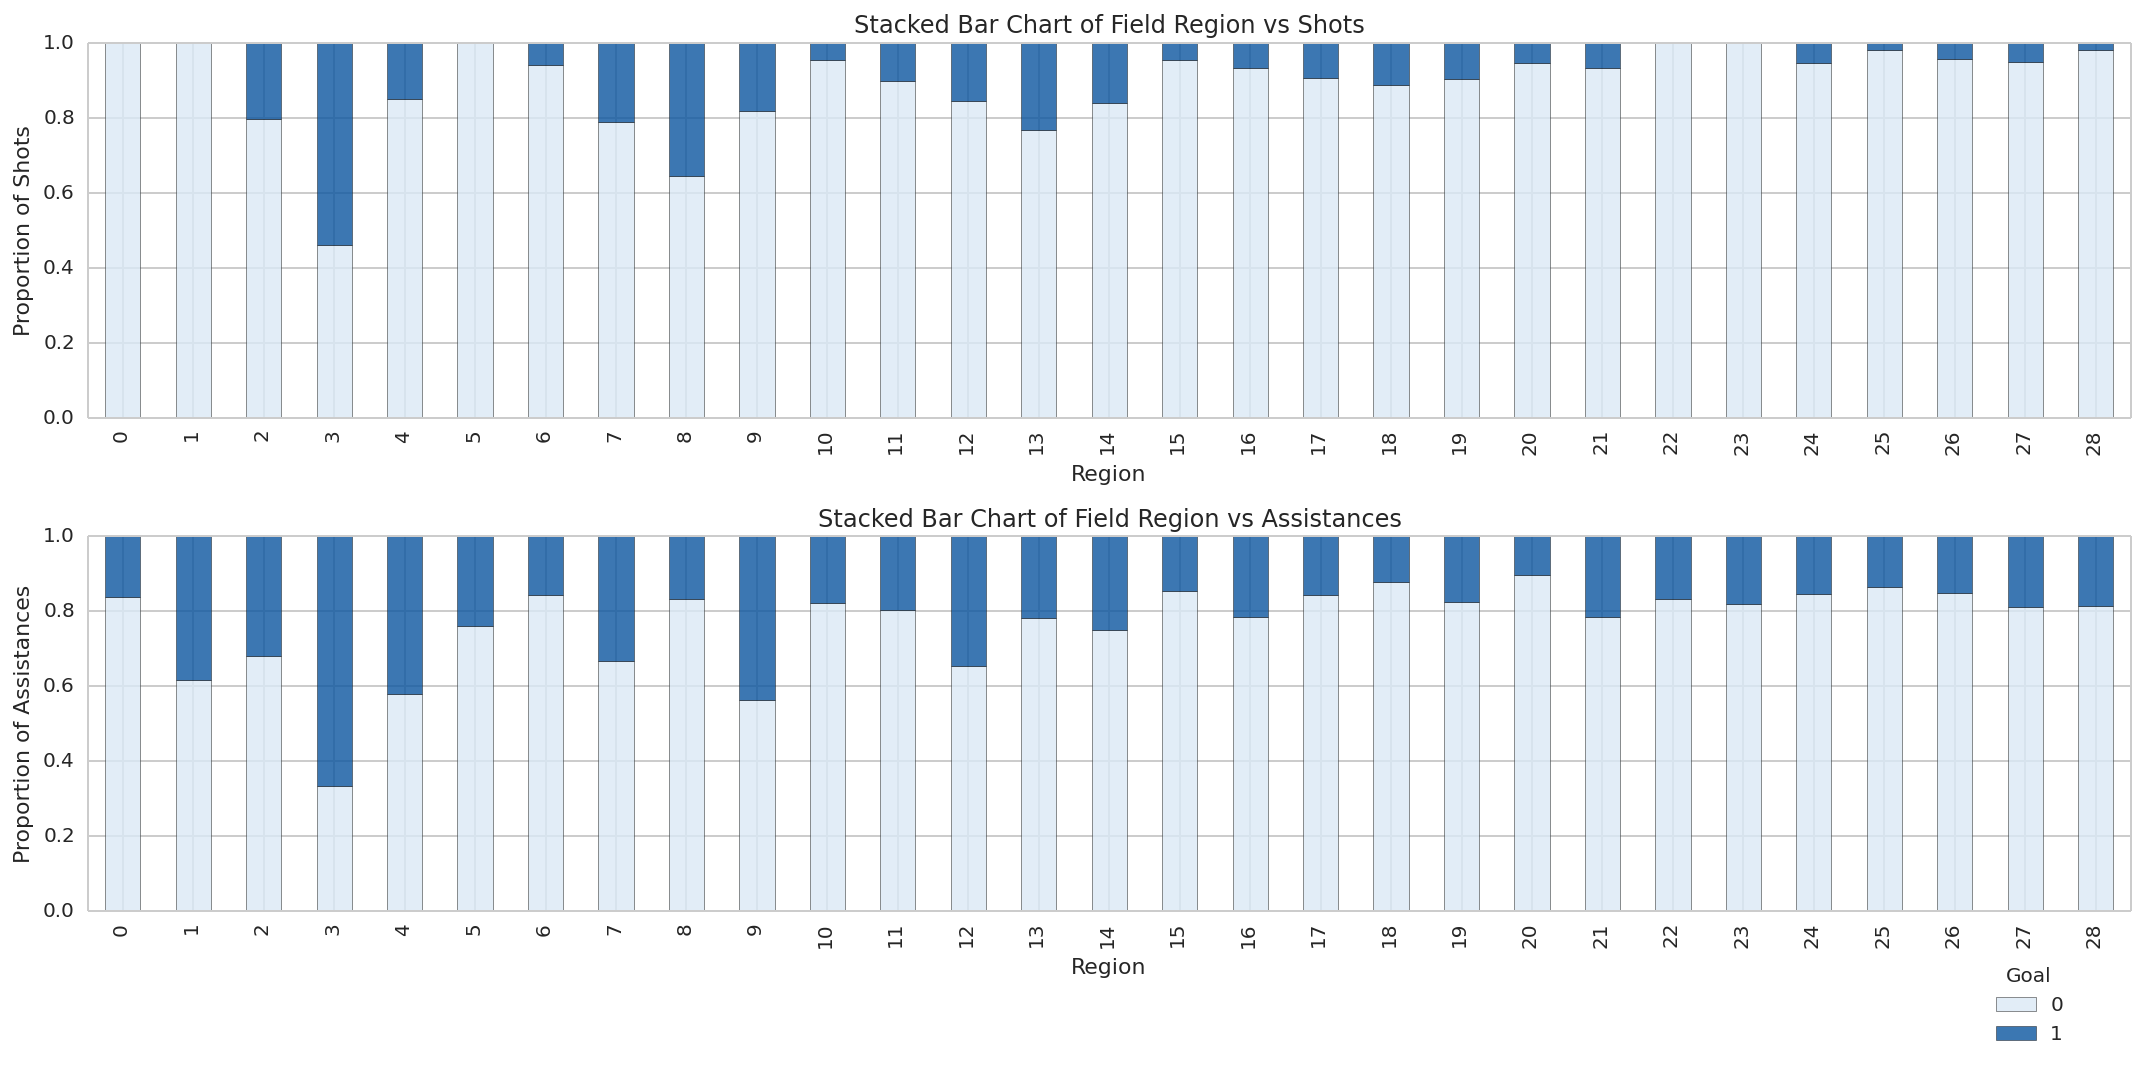

In [12]:
mpl.rcParams['figure.figsize'] = (15,7)
fig,(ax1,ax2) = plt.subplots(2)

table=pd.crosstab(shots_df.region_shot,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Stacked Bar Chart of Field Region vs Shots')
ax1.set_xlabel('Region')
ax1.set_ylabel('Proportion of Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.region_assistance,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Field Region vs Assistances')
ax2.set_xlabel('Region')
ax2.set_ylabel('Proportion of Assistances')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()


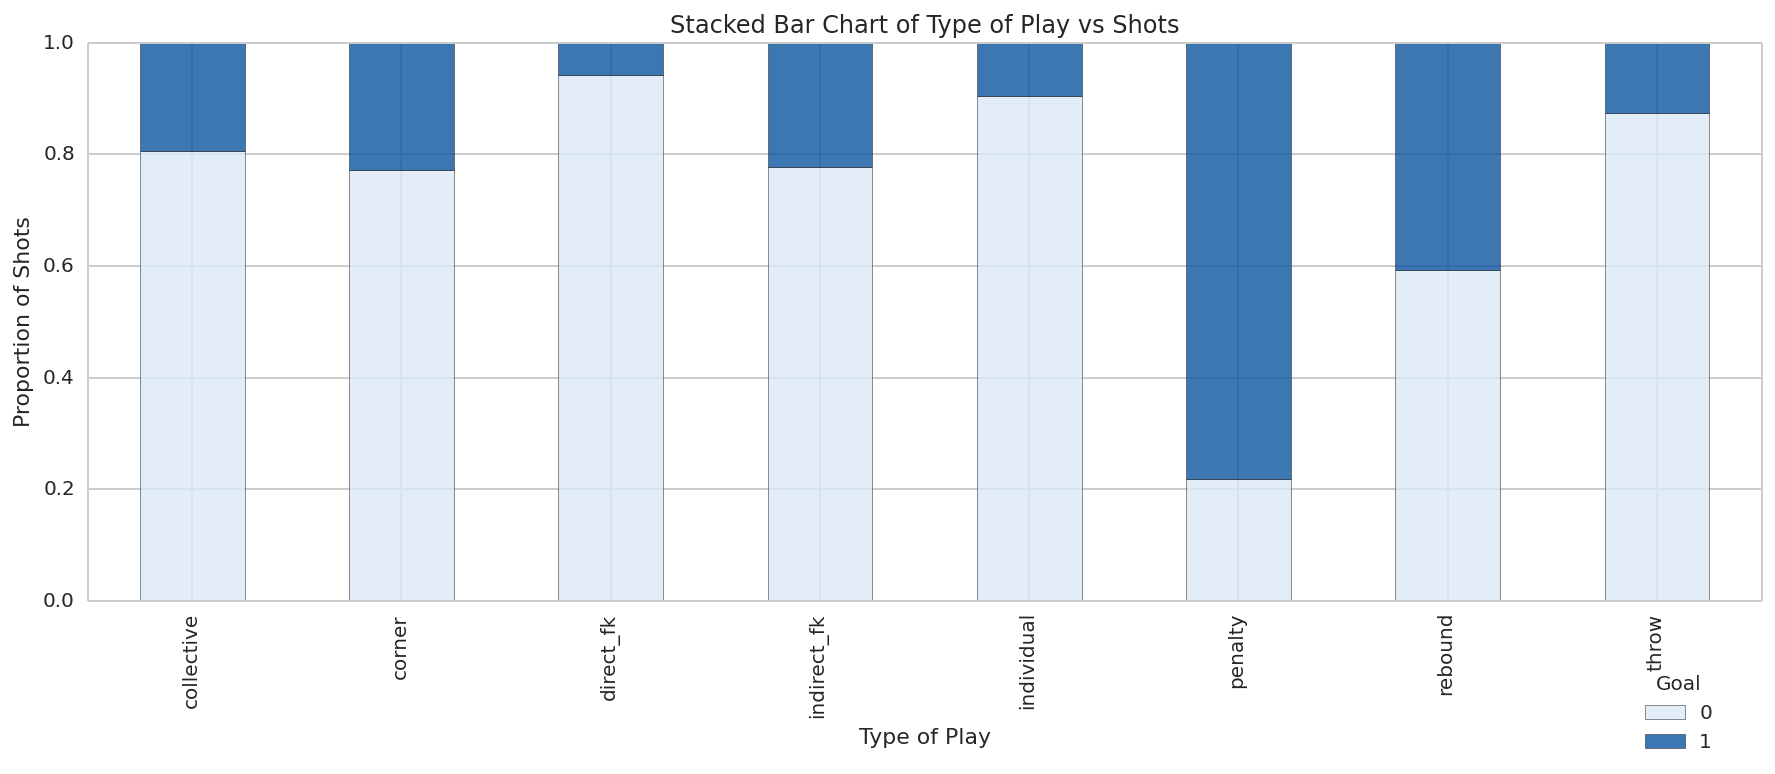

In [13]:
mpl.rcParams['figure.figsize'] = (15,5)
table=pd.crosstab(shots_df.type_of_play,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8)
plt.title('Stacked Bar Chart of Type of Play vs Shots')
plt.xlabel('Type of Play')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")

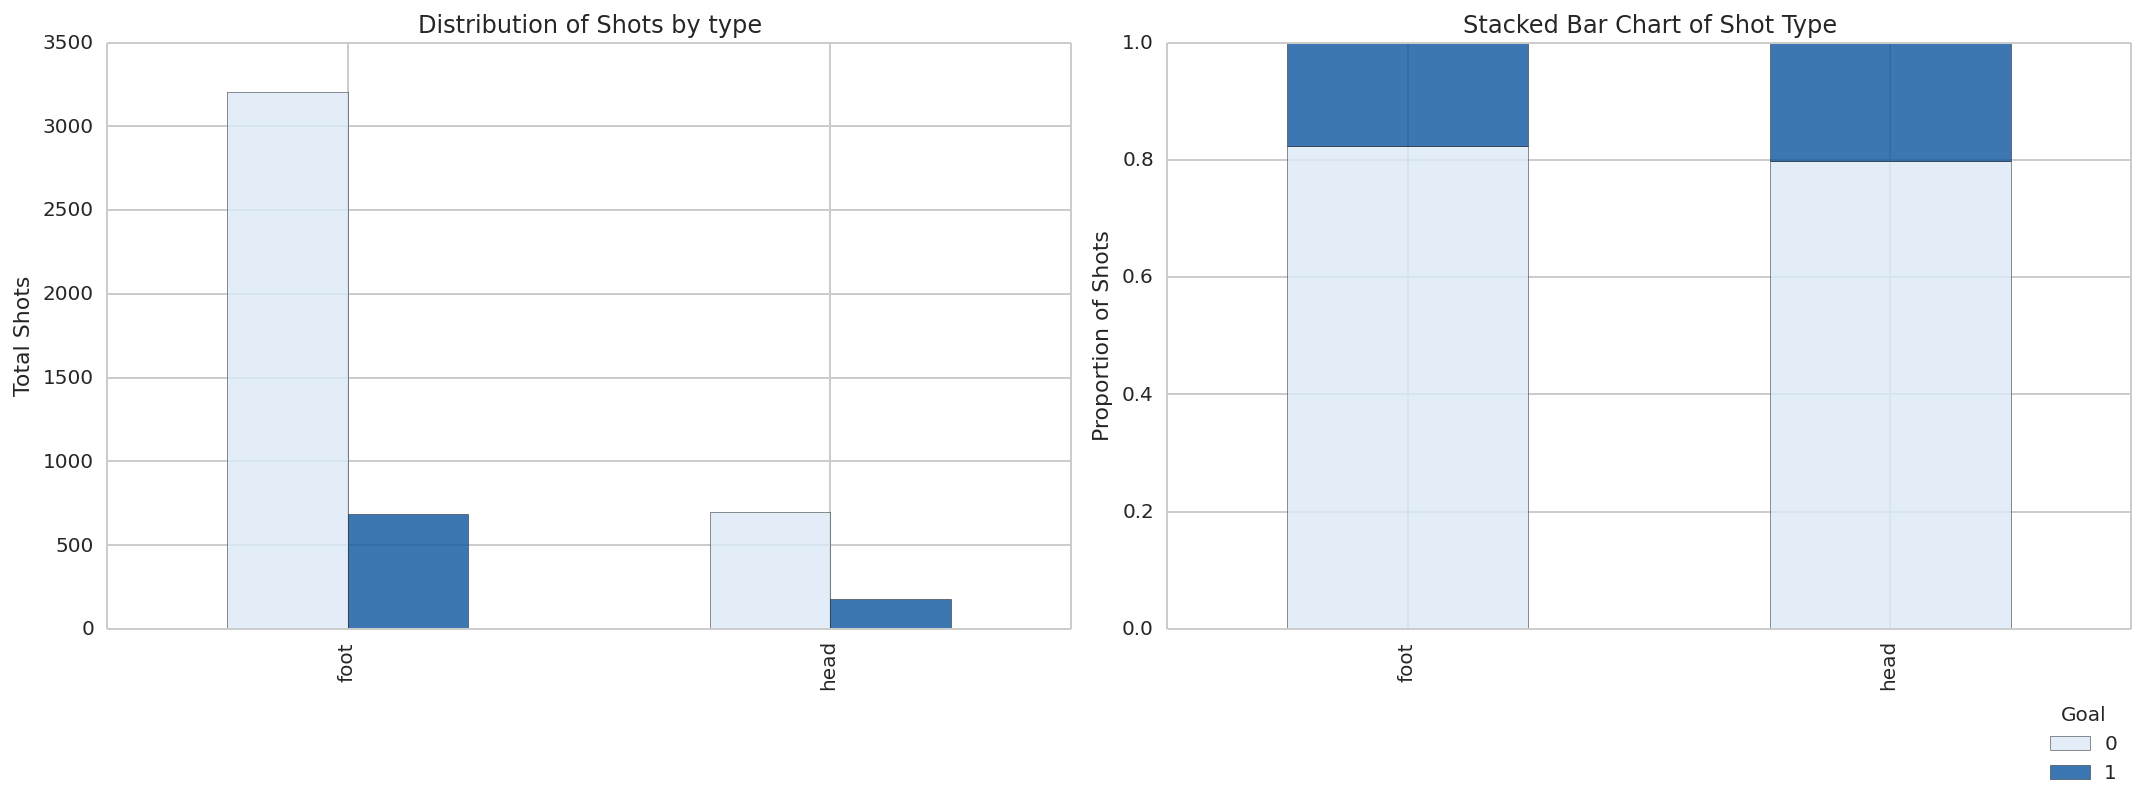

In [14]:
mpl.rcParams['figure.figsize'] = (15,5)
fig,(ax1,ax2) = plt.subplots(1,2)

pd.crosstab(shots_df.type_of_shot,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Distribution of Shots by type')
ax1.set_xlabel('')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.type_of_shot,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Shot Type')
ax2.set_xlabel('')
ax2.set_ylabel('Proportion of Shots')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

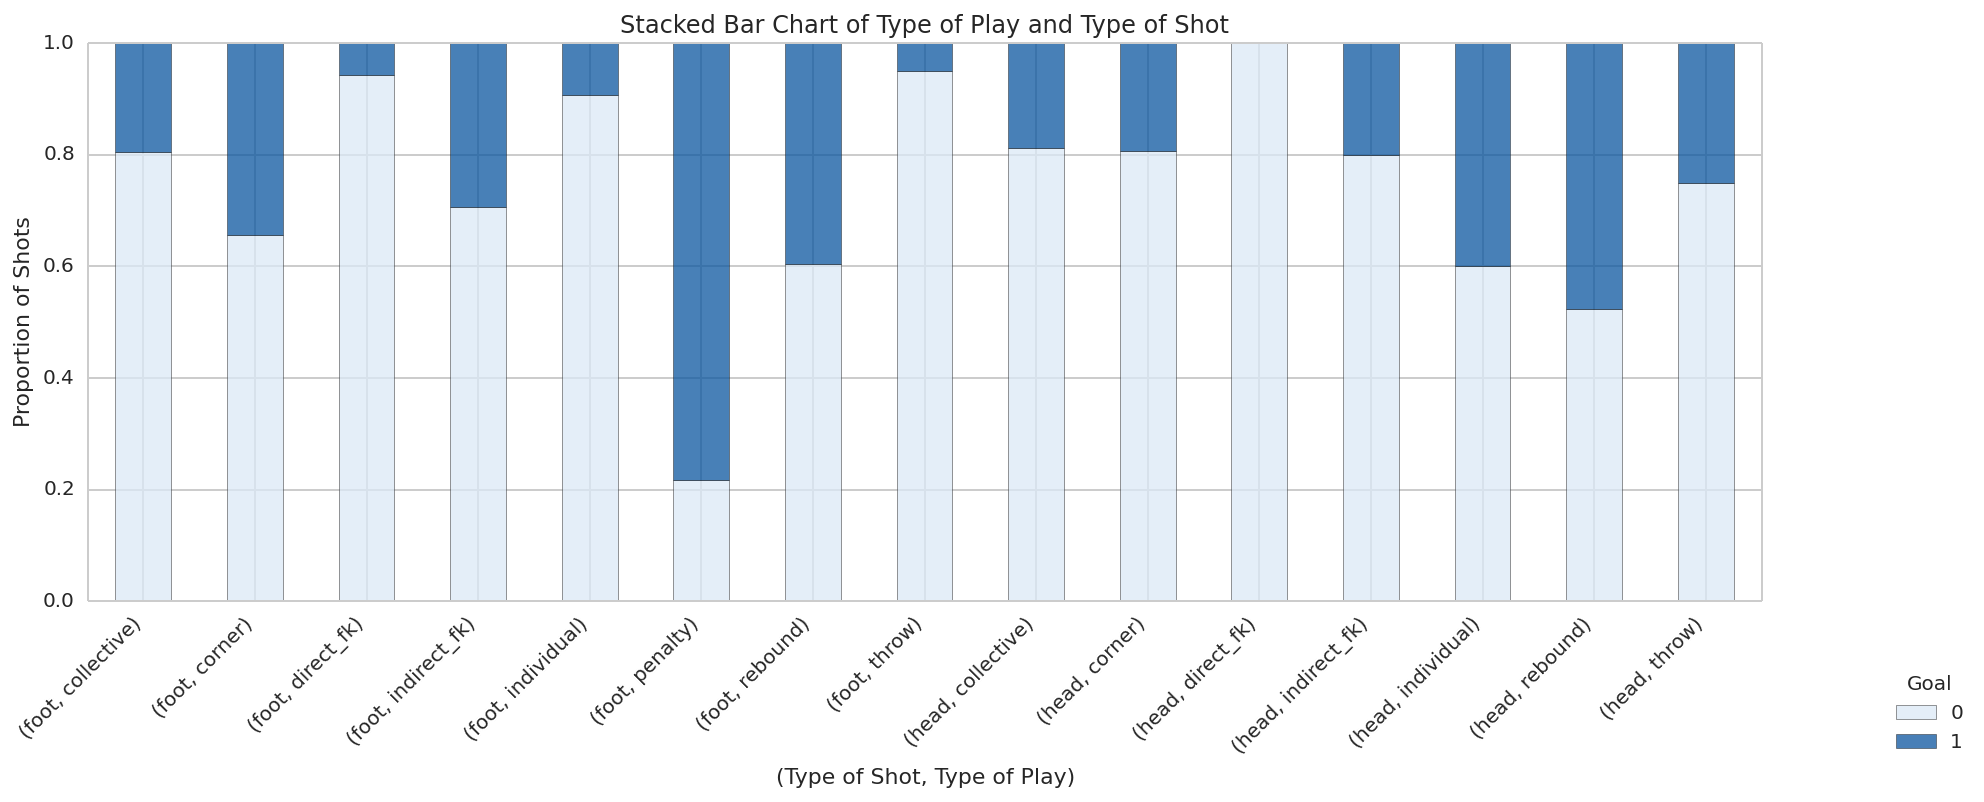

In [15]:
mpl.rcParams['figure.figsize'] = (15,5)

table=pd.crosstab([shots_df.type_of_shot,shots_df.type_of_play],shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.75, rot=45)
plt.title('Stacked Bar Chart of Type of Play and Type of Shot')
plt.xlabel('(Type of Shot, Type of Play)')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(1.1, -0.1), title="Goal")
plt.xticks(ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

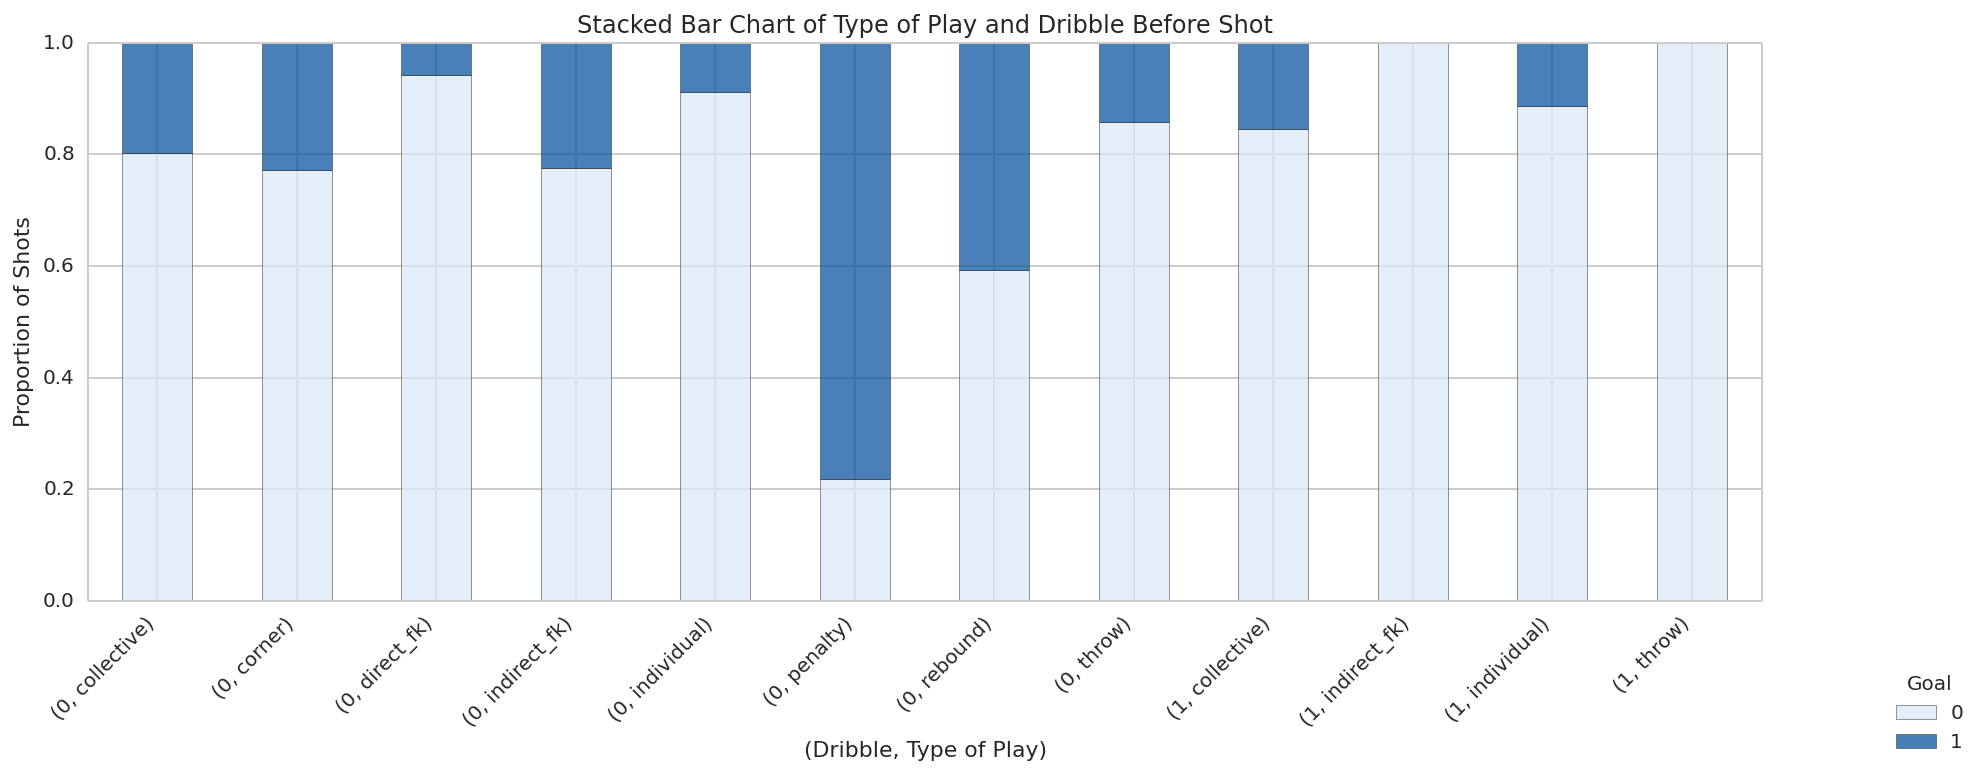

In [16]:
mpl.rcParams['figure.figsize'] = (15,5)

table=pd.crosstab([shots_df.dribble_before_shot,shots_df.type_of_play],shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.75, rot=45)
plt.title('Stacked Bar Chart of Type of Play and Dribble Before Shot')
plt.xlabel('(Dribble, Type of Play)')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(1.1, -0.1), title="Goal")
plt.xticks(ha='right')

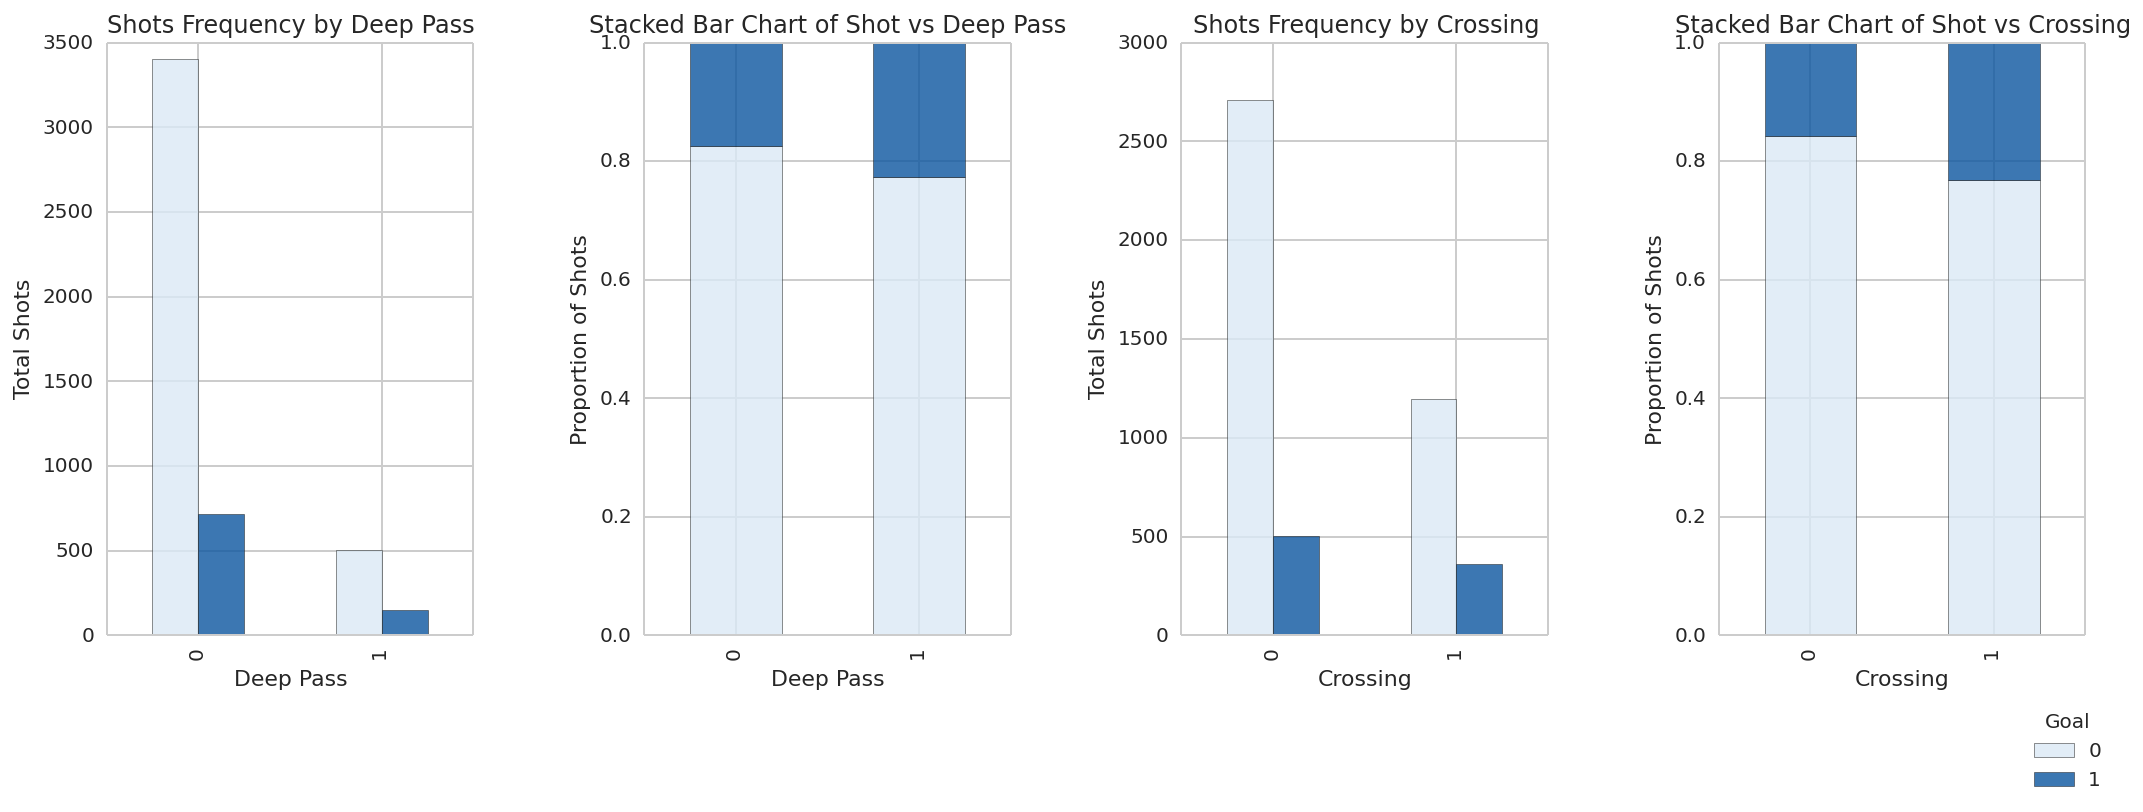

In [17]:
mpl.rcParams['figure.figsize'] = (15,5)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)

pd.crosstab(shots_df.deep_pass,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Shots Frequency by Deep Pass')
ax1.set_xlabel('Deep Pass')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.deep_pass,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Shot vs Deep Pass')
ax2.set_xlabel('Deep Pass')
ax2.set_ylabel('Proportion of Shots')
ax2.legend().set_visible(False)

pd.crosstab(shots_df.cross,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax3)
ax3.set_title('Shots Frequency by Crossing')
ax3.set_xlabel('Crossing')
ax3.set_ylabel('Total Shots')
ax3.legend().set_visible(False)

table=pd.crosstab(shots_df.cross,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax4)
ax4.set_title('Stacked Bar Chart of Shot vs Crossing')
ax4.set_xlabel('Crossing')
ax4.set_ylabel('Proportion of Shots')
ax4.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()

# Matches data

In [18]:
match_df.head()

,week,home_team,away_team,home_goals,away_goals,week_day,time,home_passes,home_wrong_passes,away_passes,...,home_shots_on_target,home_shots_off_target,away_shots_on_target,away_shots_off_target,home_fouls,away_fouls,home_tackles,home_wrong_tackles,away_tackles,away_wrong_tackles
0,1,Flamengo,Sport,1,0,SAT,16,471,41,322,...,5,6,1,0,18,15,24,1,19,3
1,1,Atletico MG,Santos,1,0,SAT,18,249,37,444,...,6,15,4,8,17,11,26,6,9,2
2,1,Coritiba,Cruzeiro,1,0,SAT,21,304,41,349,...,6,8,1,3,20,22,17,3,19,2
3,1,Corinthians,Gremio,0,0,SUN,16,470,44,283,...,1,15,2,4,12,19,24,1,22,3
4,1,Botafogo,Sao Paulo,0,1,SUN,11,434,32,189,...,6,5,1,3,8,10,9,1,17,4


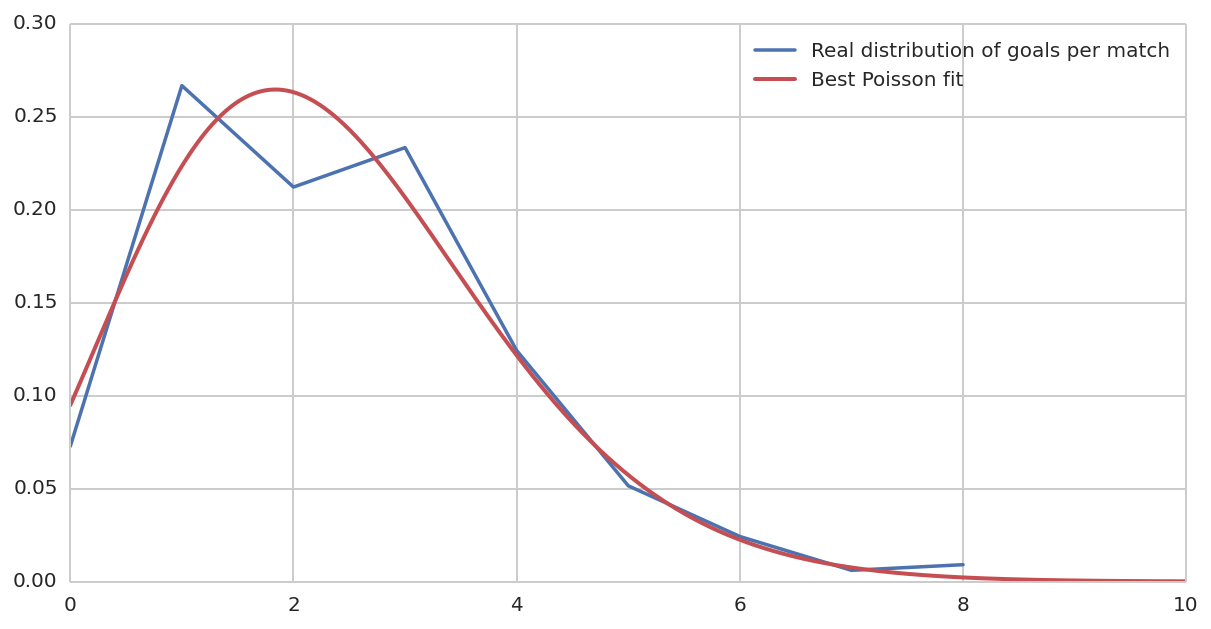

In [19]:
goals_per_match = []
for k in range(len(match_df["home_goals"])):
    goals_per_match.append(match_df["home_goals"][k]+match_df["away_goals"][k])

goals, percentage_of_goals = zip(*[[goals,goals_per_match.count(goals)/float(len(match_df["home_goals"]))] for goals in set(goals_per_match)])

def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

parameters, cov_matrix = curve_fit(poisson, goals, percentage_of_goals)

mpl.rcParams['figure.figsize'] = (10,5)
plt.plot(goals,percentage_of_goals,label="Real distribution of goals per match")
x_plot = np.linspace(0, 10, 1000)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2, label="Best Poisson fit")
plt.legend()
plt.show()


# Logistic Regression

In [53]:
cat_vars=['region_assistance','region_shot','type_of_play','type_of_shot']
vars_to_discard=['index','week','minute','shot_player','assistance_player','team','opponent']
#                 'good_chance', 'defense_mistake', 'dangerous_shot']
shots_dummy_df = shots_df
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(shots_dummy_df[var], prefix=var)
    shots_dummy_df_1=shots_dummy_df.join(cat_list)
    shots_dummy_df=shots_dummy_df_1

data_vars=shots_dummy_df.columns.values.tolist()
to_keep=[i for i in data_vars if (i not in cat_vars and i not in vars_to_discard)]

In [54]:
data_final=shots_dummy_df[to_keep]
data_final.columns.values


array(['goal', 'goal_difference', 'at_home', 'dribble_before_shot',
       'deep_pass', 'cross', 'counter_attack', 'good_chance',
       'defense_mistake', 'dangerous_shot', 'region_assistance_0',
       'region_assistance_1', 'region_assistance_2', 'region_assistance_3',
       'region_assistance_4', 'region_assistance_5', 'region_assistance_6',
       'region_assistance_7', 'region_assistance_8', 'region_assistance_9',
       'region_assistance_10', 'region_assistance_11',
       'region_assistance_12', 'region_assistance_13',
       'region_assistance_14', 'region_assistance_15',
       'region_assistance_16', 'region_assistance_17',
       'region_assistance_18', 'region_assistance_19',
       'region_assistance_20', 'region_assistance_21',
       'region_assistance_22', 'region_assistance_23',
       'region_assistance_24', 'region_assistance_25',
       'region_assistance_26', 'region_assistance_27',
       'region_assistance_28', 'region_shot_0', 'region_shot_1',
       'region_

In [55]:
data_final_vars=data_final.columns.values.tolist()
y=['goal']
X=[i for i in data_final_vars if i not in y]


## Feature Selection

In [56]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg)
rfe = rfe.fit(data_final[X], data_final[y] )

print rfe.support_
print rfe.ranking_

[False False False False False False  True  True  True False  True False
  True  True False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True False  True  True  True
  True False  True  True  True  True False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True]
[33 39 14 20 31 37  1  1  1  3  1 35  1  1 32  4 29 17  1  5  9  1 30 27  6
 38 25  2 16 12 18  8 15 11  7 34 26 28  1  1  1  1  1  1 21  1  1  1  1 36
  1  1  1  1 22 23 40 24 13 10  1  1  1  1  1  1  1  1  1  1  1  1  1 19  1
  1  1]


In [57]:
true_features = [category for category,true_feature in zip(X,rfe.support_) if true_feature]
true_features

['good_chance',
 'defense_mistake',
 'dangerous_shot',
 'region_assistance_1',
 'region_assistance_3',
 'region_assistance_4',
 'region_assistance_9',
 'region_assistance_12',
 'region_shot_0',
 'region_shot_1',
 'region_shot_2',
 'region_shot_3',
 'region_shot_4',
 'region_shot_5',
 'region_shot_7',
 'region_shot_8',
 'region_shot_9',
 'region_shot_10',
 'region_shot_12',
 'region_shot_13',
 'region_shot_14',
 'region_shot_15',
 'region_shot_22',
 'region_shot_23',
 'region_shot_24',
 'region_shot_25',
 'region_shot_26',
 'region_shot_27',
 'region_shot_28',
 'type_of_play_collective',
 'type_of_play_corner',
 'type_of_play_direct_fk',
 'type_of_play_indirect_fk',
 'type_of_play_individual',
 'type_of_play_penalty',
 'type_of_play_throw',
 'type_of_shot_foot',
 'type_of_shot_head']

In [58]:
X=data_final[true_features]
y=data_final['goal']

## Implementing the model


In [63]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs') # avoid singular matrix - look for scipy's 'bfgs'
print result.summary()

         Current function value: 0.328996
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                 4771
Model:                          Logit   Df Residuals:                     4733
Method:                           MLE   Df Model:                           37
Date:                Wed, 04 Apr 2018   Pseudo R-squ.:                  0.3054
Time:                        19:03:17   Log-Likelihood:                -1569.6
converged:                      False   LL-Null:                       -2259.9
                                        LLR p-value:                5.365e-266
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
good_chance                 -1.0179      0.111  

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Logistic Regression Model Fitting


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
y_pred = logreg.predict(X_test)
print 'Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test))

Accuracy of logistic regression classifier on test set: 0.86


## Cross Validation


In [66]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print "10-fold cross validation average accuracy: %.3f" % (results.mean())

10-fold cross validation average accuracy: 0.848


## Confusion Matrix


In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print confusion_matrix 

[[1154   23]
 [ 175   80]]


## Compute precision, recall, F-measure and support


In [68]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.87      0.98      0.92      1177
          1       0.78      0.31      0.45       255

avg / total       0.85      0.86      0.84      1432



## ROC Curve


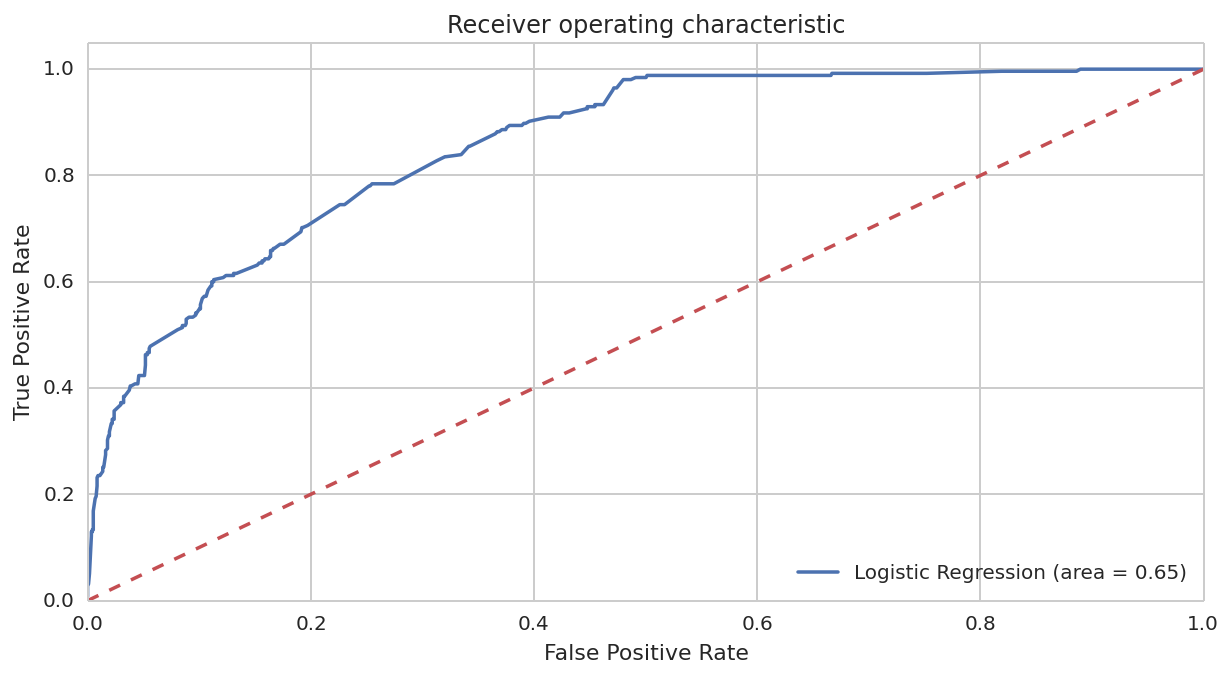

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### TODO: Check same model without subjective variables

# title 
## major headings 
### subheadings 
#### 4th level subheading